In [1]:
#Kütüphaneler
import os
import random
import matplotlib.pyplot as plt
import cv2
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

2025-09-26 08:56:32.677289: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758876993.034791      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758876993.135755      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Sınıf sayısı: 29
Örnekler: ['N', 'R', 'space', 'B', 'I', 'del', 'F', 'H', 'E', 'U']


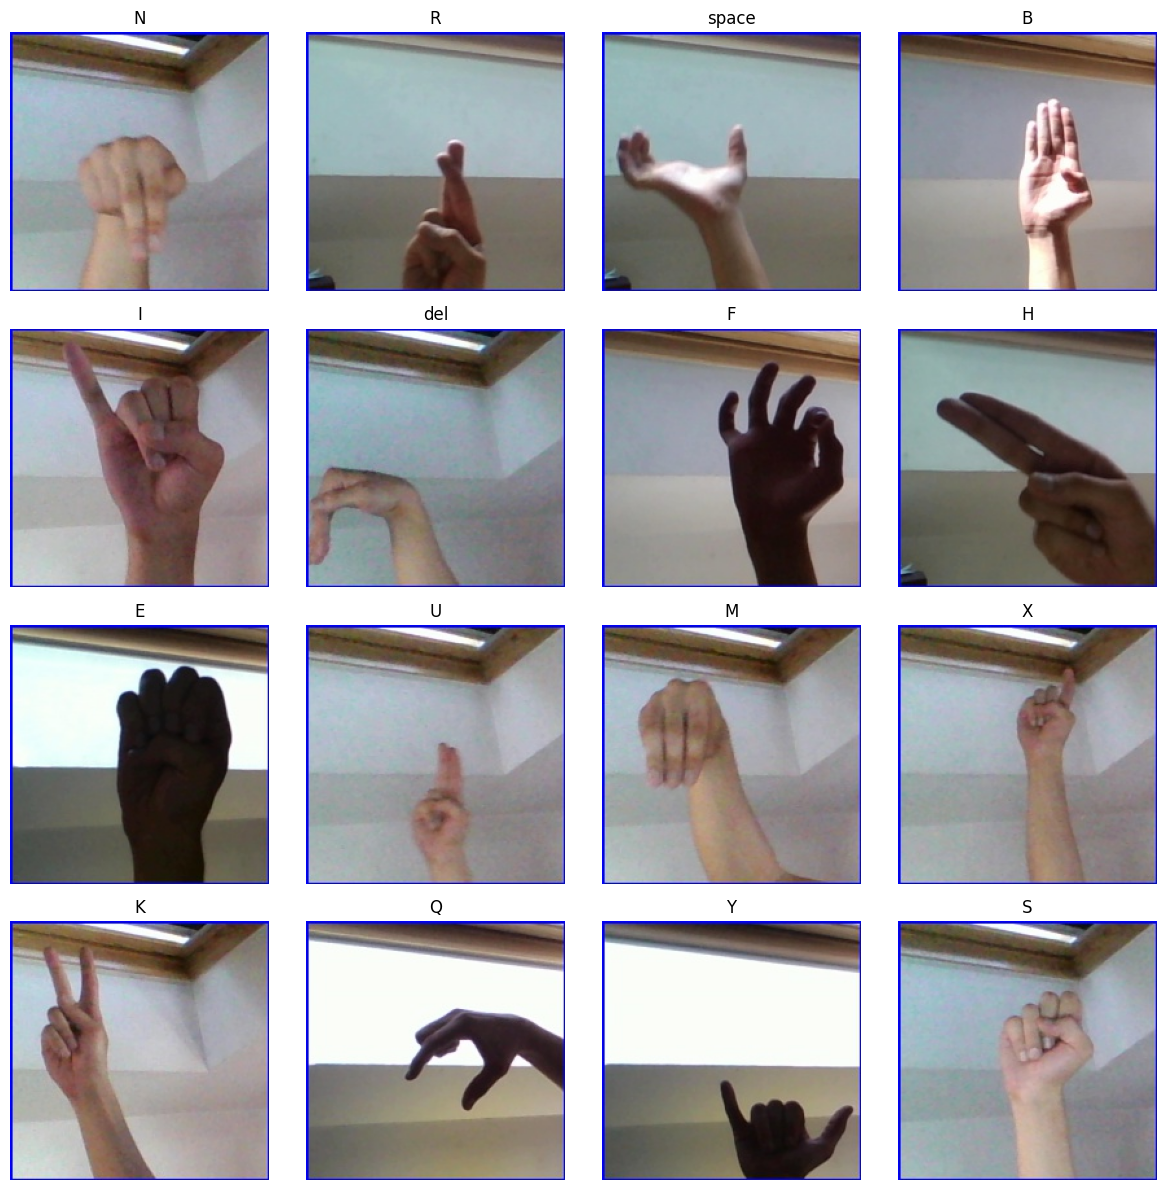

In [2]:
#Dataset Kaggle ortamına göre ayarlandı
data_dir = "/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"  

#Sınıflar listelendi
classes = os.listdir(data_dir)
print(f"Sınıf sayısı: {len(classes)}")
print(f"Örnekler: {classes[:10]}")  #İlk 10 sınıfı gösteriyor

#Örnek görseller(her sınıftan 1 görsel olarak seçildi) çizildi
plt.figure(figsize=(12, 12))

for i, cls in enumerate(classes[:16]):  # İlk 16 sınıf için örnek
    cls_path = os.path.join(data_dir, cls)
    img_name = os.listdir(cls_path)[0]  # İlk görseli al
    img_path = os.path.join(cls_path, img_name)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(4, 4, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.tight_layout()
plt.show()




**Veri Seti İncelemesi & Görselleştirme**

Bu projede kullanılan veri seti ASL Alphabet Dataset'tir. Bu dataset, Amerikan İşaret Dili alfabesindeki harflerin ve özel sembollerin görsellerinden oluşuyor. Veri setinde:toplam 29 sınıf var. Bu sınıflar; 26 harf ve `space`, `del`, `nothing` gibi özel semboller içeriyor. Yukarıda her sınıftan 1 tane seçilmiş 16 örnek görsel gösterildi.


In [3]:
original_data_dir = "/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"
base_dir = "/kaggle/working/asl_split"#Train & validation & test in saklanacağı yeni klasör

#Klasörleri oluşturma adımları
os.makedirs(base_dir, exist_ok=True)
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(base_dir, split), exist_ok=True)
    for cls in os.listdir(original_data_dir):
        os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)

#%70 train & %15 validation & %15 test ayrıldı
for cls in os.listdir(original_data_dir):
    cls_path = os.path.join(original_data_dir, cls)
    files = os.listdir(cls_path)[:1000]#Zaman kazandırmak için ilk 1000 örnek kullanıldı.
    
    train_files, temp_files = train_test_split(files, test_size=0.3, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

    #Train & validation & test ayrı klasörlere kopyalandı
    for f in train_files:
        shutil.copy(os.path.join(cls_path, f), os.path.join(base_dir, 'train', cls))
    for f in val_files:
        shutil.copy(os.path.join(cls_path, f), os.path.join(base_dir, 'val', cls))
    for f in test_files:
        shutil.copy(os.path.join(cls_path, f), os.path.join(base_dir, 'test', cls))

In [4]:
#Veri çoğaltma
train_datagen = ImageDataGenerator(
    rescale=1./255, #Piksel değerleri 0-1 aralığına getirildi.
    rotation_range=15,       
    width_shift_range=0.1,   
    height_shift_range=0.1,  
    zoom_range=0.1,          
    horizontal_flip=True     
)

val_test_datagen = ImageDataGenerator(rescale=1./255) #Validation ve test setlerinin normalize edildi.

#Eğitim için veri seti hazırlandı
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

#Validation seti normalize edildi
val_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)
#Test seti normalize edildi
test_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 20300 images belonging to 29 classes.
Found 4350 images belonging to 29 classes.
Found 4350 images belonging to 29 classes.


****Data Augmentation:****

ASL datasetinde harfler görsel olarak birbirine benzediği için açısal kaymalar modelin bu ayrımı öğrenmesini zorlaştırabilir. Bu yüzden rotation_range=15 ile döndürme uygulandı.

In [5]:
#CNN Modeli
model = Sequential([
    #Convolution & Pooling 
    Conv2D(32, (3,3), activation='relu', padding='same'),#Az filtre ile overfitting riski azaltıldı  
    MaxPooling2D((2,2)),#Daha az parametre ile öğrenim sağlandı                   
    
    Conv2D(64, (3,3), activation='relu', padding='same'),#Modelin derinleşmesi için daha çok filtre uygulandı
    MaxPooling2D((2,2)),
    
    Conv2D(128, (3,3), activation='relu', padding='same'),  
    MaxPooling2D((2,2)),
    
    #Flatten & Dense
    Flatten(),#Feature map’ler tek boyuta indirildi, Dens'e hazırlandı                           
    Dense(128, activation='relu'),#Öğrenilen özellikleri sınıflandırmaya hazırlandı.       
    Dropout(0.5),#Overfitting’i azaltıldı
    Dense(29, activation='softmax')#Olasılık dağılımı sağlandı        
])
#Modelin özeti
model.summary()

I0000 00:00:1758877202.609910      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758877202.610604      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [6]:
#Model compile edildi
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [7]:
#Model eğitildi
history = model.fit(
    train_generator,         
    epochs=10,#Küçük dataset
    validation_data=val_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1758877205.707369     123 service.cc:148] XLA service 0x78c71c0061e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758877205.708694     123 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758877205.708719     123 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758877206.291373     123 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/635 ━━━━━━━━━━━━━━━━━━━━ 29s 47ms/step - accuracy: 0.0748 - loss: 3.3768

I0000 00:00:1758877210.147526     123 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


635/635 ━━━━━━━━━━━━━━━━━━━━ 49s 65ms/step - accuracy: 0.0691 - loss: 3.2659 - val_accuracy: 0.3834 - val_loss: 1.9880
Epoch 2/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 37s 58ms/step - accuracy: 0.3161 - loss: 2.1848 - val_accuracy: 0.5966 - val_loss: 1.2414
Epoch 3/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 37s 58ms/step - accuracy: 0.4794 - loss: 1.5666 - val_accuracy: 0.7720 - val_loss: 0.7471
Epoch 4/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 37s 58ms/step - accuracy: 0.5715 - loss: 1.2432 - val_accuracy: 0.7795 - val_loss: 0.6653
Epoch 5/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 37s 58ms/step - accuracy: 0.6287 - loss: 1.0524 - val_accuracy: 0.8545 - val_loss: 0.4678
Epoch 6/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 38s 60ms/step - accuracy: 0.6802 - loss: 0.9229 - val_accuracy: 0.9041 - val_loss: 0.3504
Epoch 7/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 37s 58ms/step - accuracy: 0.7121 - loss: 0.8027 - val_accuracy: 0.8906 - val_loss: 0.3458
Epoch 8/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 37s 58ms/step - accuracy: 0.7468 - loss: 0.7264 - val_accurac

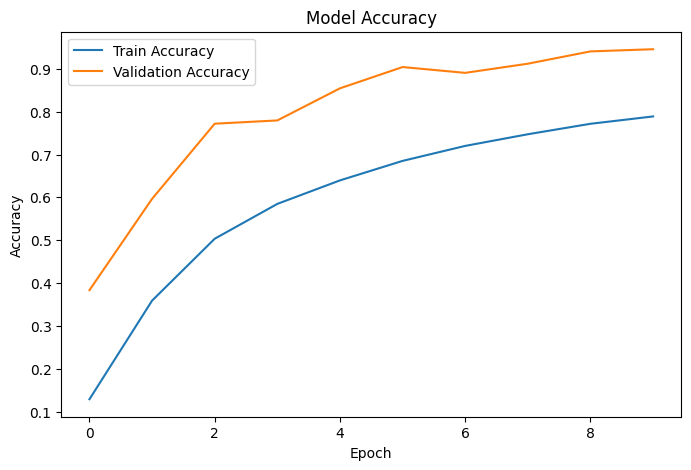

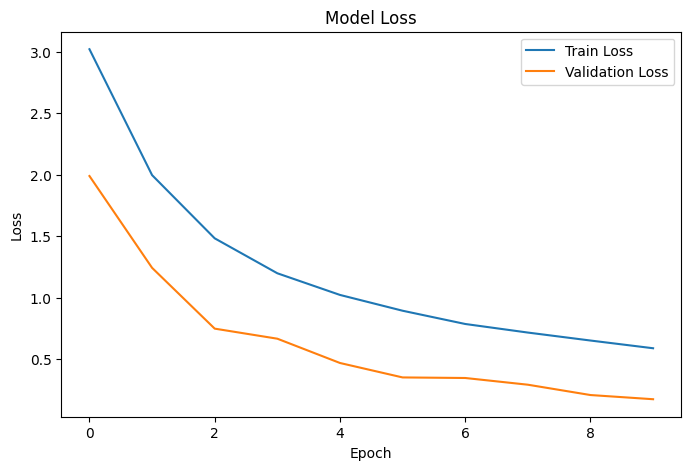

In [8]:
#Eğitim ve doğrulama accuracy grafiği çizildi
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Eğitim ve doğrulama loss grafiği çizildi
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Model küçük dataset ile çalıştırıldı. Böylece daha hızlı çalıştı. Accuracy ve loss grafikleri ile overfitting olmadığı gözlemlendi. Epoch 6’dan sonra validation accuracy stabil hale geldi. Loss grafiği düzenli olarak azaldı,öğrenme süreci başarıyla tamamlanmış oldu. Model kaydedilebilir ve test seti ile değerlendirme yapıldı.

In [9]:
# Test setinde model performansını ölçüldü
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")

136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9599 - loss: 0.1405
Loss: 0.1705
Accuracy: 0.9492


In [10]:
# Test setinde tahminler edildi
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred_classes)
print("Confusion Matrix:\n", cm)

# Classification Rapor
report = classification_report(test_generator.classes, y_pred_classes, target_names=classes)
print(report)


136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
Confusion Matrix:
 [[147   0   0   0   1   0   0   0   0   0   0   0   1   0   0   0   0   0
    0   1   0   0   0   0   0   0   0   0   0]
 [  1 148   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   1   0   0   0   0   0   0   0   0]
 [  0   0 150   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 149   0   0   0   0   0   0   0   0   0   0   1   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [ 19   0   0   0 130   0   0   0   1   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 146   0   0   0   0   0   0   0   0   0   0   0   0
    0   3   0   0   0   0   1   0   0   0   0]
 [  0   0   0   0   0   0 139  10   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   1   0   0   0   0   0]
 [  0   0   0   0   0   0   3 147   0   0   0   0   0   0   0   0   0   0
    0   0   0   0 

**Performans Analizi**

Confusion Matrix ile hangi sınıfların yanlış sınıflandırıldığını gösterildi. Classification Raporu precision, recall ve F1-score değerleri ile her sınıfın performansı incelendi.